# Imports and Folder settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import tifffile

import trackpy as tp
import pims

import glob # for tif folder function
import json

import time
import os

from scipy.spatial import cKDTree

from tqdm import tqdm

In [2]:
sim_name = "test_1"
output_dir = os.path.join("results", sim_name)

# Simulation section

In [2]:
import simulation_v3 as simulation

In [3]:
# set parameters
temperature=298.15            # Room temperature
viscosity=1.0e-3              # Water viscosity
mean_particle_radius=50e-9    # 50 nm radius (100 nm diameter) 
std_particle_radius=10e-9     # 10 nm std dev (~20 nm for diameter)
frame_size=(512, 512)        # Frame size
pixel_size=100e-9,             # Pixel size (100 nm)
z_range=(-10e-6, 10e-6)      # -10 to 10 micrometers in z
focal_plane=0.0               # Focal plane at z=0
depth_of_field=2e-6           # 2 micrometer depth of field
diffusion_time=0.1            # Time between frames
num_particles=100             # Number of particles
gaussian_sigma=1.0           # Base sigma for Gaussian
brightness_factor=1.0        # Brightness scaling factor
snr_base=5.0                  # Base SNR for smallest particle
snr_scaling=2.0               # SNR scaling with size
background_noise_alpha= 2.0    
background_noise_beta = 0.02
do_background_noise = True
noise_floor=50.0              # Baseline noise floor (in 16-bit scale)
noise_ceiling=2500.0          # Maximum expected pixel value (in 16-bit scale)


simulation.main(temperature, viscosity, mean_particle_radius, std_particle_radius, frame_size, pixel_size, z_range, focal_plane, 
         depth_of_field, diffusion_time, num_particles, gaussian_sigma, brightness_factor, snr_base, snr_scaling, 
         background_noise_alpha, background_noise_beta, noise_floor, noise_ceiling, sim_name)



Saved size distribution plot to results\test_1\size_distribution.png
Generating 3D simulation with focal plane effects...


Generating Frames:   5%|███▏                                                           | 5/100 [00:00<00:01, 47.73it/s]


Frame Pixel Statistics (0-1 scale):
  Min: 0.005498
  Max: 0.464198
  Mean: 0.040890
  0th percentile: 0.005498
  25th percentile: 0.027764
  50th percentile: 0.037164
  75th percentile: 0.050005
  90th percentile: 0.064884
  95th percentile: 0.075537
  99th percentile: 0.099586
  99.999th percentile: 0.389358

Frame Pixel Statistics (16-bit scale, 0-65535):
  Min: 360
  Max: 30421
  Mean: 2679.71
  0th percentile: 360
  25th percentile: 1819
  50th percentile: 2435
  75th percentile: 3277
  90th percentile: 4252
  95th percentile: 4950
  99th percentile: 6526
  99.999th percentile: 25516



Generating Frames: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.39it/s]


Simulation complete. Total time: 1.9 seconds
Average time per frame: 0.019 seconds
Saved GIF to results\test_1\simulation_v3.gif
Saved 16-bit TIF to results\test_1\simulation_v3.tif
Saved metadata to results\test_1\simulation_v3_metadata.json
Saved track data to results\test_1\simulation_v3_tracks.csv
Saved track data to results\test_1\simulation_v3_tracks.json
Generating visualization plots...
Saved 3D positions plot to results\test_1\3d_positions.png
Saved depth vs. brightness plot to results\test_1\depth_vs_brightness.png
3D simulation complete. Results saved in 'results/test_1' directory.


# Track making with ground truth and location estimates from TrackPy

Table of trackPy.locate() parameters:


Table of trackPy.locate() output:
| Name    | Definition | Measure and Range         |
|---------|-----|-------------|
| mass    | Sum of the pixel intensities inside the detected feature. It is a measure of the total brightness of the particle.  | sum (normally hundreds of thousands for 16 bit images    |
| size    | Gaussian width (σ) of the detected feature, which approximates the particle’s spatial extent.  | Pixels |
| ecc     | Eccentricity. Shape parameter describing how elongated the detected particle is. It is 0 for a perfect circle and approaches 1 for a highly elongated shape.  | 0 to 1     |
| signal  | Peak intensity of the detected feature (after background subtraction). It represents the brightest pixel in the detected particle.  | Pixel brightness |
| raw_mass| Sum of intensities in the particle region before background subtraction  | sum (normally hundreds of thousands for 16 bit images     |
| ep      | An estimate of the subpixel localization precision, based on image noise. Lower values indicate more precise localization.  | Usually between 0.01 and 1 pixels. Lower values (e.g., <0.1 pixels) indicate high-confidence localization. |

**note:** negative ep values can occur due to numerical instability or incorrect assumptions in the estimation formula.



### trackPy grading function

In [4]:
def grade_estimate(nearest, features, g_x, g_y, outputs):
    #print("Ground truth:", g_x, g_y)

    best_feature = None
    best_score = np.inf

    # for now, just return the first nearest neighbor with a non negative precision
    
    for i in range(len(nearest)):
        dist = nearest[0][i]
        index = nearest[1][i]

        if dist != np.inf:
            feature = features.iloc[index]
            
            # check if ep is negative (invalid)
            if feature["ep"] < 0 or feature["ep"] > 100:
                continue

            #print(feature)
            
            f_x = feature["x"]
            f_y = feature["y"]
            f_signal = feature["signal"]
            f_ep = feature["ep"]
            #print(f"{f_x:.2f}", f"{f_y:.2f}", f"{f_signal:.2f}", f"{f_ep:.2f}")

            return feature.loc[outputs]
            
    return None
    

### Run through Frames

In [5]:
# trackPy parameters
diameter = 9
minmass = 100
characterize = True

# trackPy outputs to be recorded
tp_outputs = ["x", "y", "size", "signal", "ep"]

# cKDTree query parameters
max_dist = 10
k = 5

# file paths for simulation information
tif_sequence = os.path.join(output_dir, "simulation_v3.tif")
tracks_csv =   os.path.join(output_dir, "simulation_v3_tracks.csv")
tracks_json =  os.path.join(output_dir, "simulation_v3_tracks.json")
sim_metadata = os.path.join(output_dir, "simulation_v3_metadata.json")

# file paths for output
est_df_output = os.path.join(output_dir, "ground_and_trackPy_output.xlsx")


# load simulation information (mainly pixel size)
sim_meta = None
with open(sim_metadata, "r") as file:
    sim_meta = json.load(file)

pixel_size = sim_meta['pixel_size']
num_particles = sim_meta['num_particles']


# open ground truth track CSV
ground = pd.read_csv(tracks_csv)


# create new dataframe
estimate_df = ground.copy()
# rename conflicting column names
estimate_df = estimate_df.rename(columns={'x': 'g_x', 'y': 'g_y', 'size': 'g_size'})
# add new estimate columns
for new_col in tp_outputs:
    estimate_df[new_col] = np.nan

# open simulation tif image sequence to analyze with TrackPy
sim_sequence = pims.open(tif_sequence)

num_frames = 100
for i in tqdm(range(num_frames), desc="Processing Frames"):

    # extract frame specific ground truths
    frame_truths = ground[ground["frame"] == i]
    #print(frame_truths.head())

    # create particle estimates dictionary to be merged with estimate_df
    frame_estimates = {}
    
    # move to ith frame
    frame = sim_sequence[i]

    # location estimation with TrackPy
    features = tp.locate(frame, diameter=diameter, minmass=minmass, characterize=characterize)

    
    # put features in KDTree for optimized nearest neighbors querying
    tree = cKDTree(features[['x', 'y']].values)
    
    # Go through each particle in the ground truth dataframe
    for orig_index, row in frame_truths.iterrows():

        # get current particle x,y values
        curr_x = row['x']
        curr_y = row['y']

        # query the tree
        # result includes two arrrays, first of distance and second of indexes
        nearest = tree.query([curr_x, curr_y], k=k, distance_upper_bound=max_dist)
        #print(nearest, "\n\n")

        # run grading function to return what to append to ground truth dataframe
        result = grade_estimate(nearest, features, curr_x, curr_y, outputs=tp_outputs)

        # append grading result to frame estimates dictionary
        if isinstance(result, pd.Series):
            frame_estimates[orig_index] = result

        #print("\n\n")

    #print(frame_estimates)
    
    # append frame estimates to estimates df
    frame_estimate_df = pd.DataFrame.from_dict(frame_estimates, orient="index")
    estimate_df.loc[frame_estimates.keys(), tp_outputs] =  frame_estimate_df   

estimate_df.to_excel(est_df_output)


C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
C:\Users\brandon\anaconda3\envs\Capstone\Lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: divide by zero encountered in divide
  N_S = noise / mass
Processing Frames: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


# Image analysis stuff

img_info(source, percentiles=False)


plot_tif(source, normalize=False, frame=None, subset=None
 - normalize: apply min-max normalization on image before plotting
 - frame: number of frame for multi-image til file
 - subset: [[x_start, x_end],[y_start,y_end]] plot a subset of the image.
   - **note:** normalization is based on subset (not entire image)


In [3]:
import image_tools
from image_tools import img_info

#convert_png(source, output, scale=True)
#scale_tif(source, output)
#img_info(source, percentiles=False)
#check_imgs_folder(folder, extension=None, percentiles=False)

from tif_plotting import plot_tif

#plot_tif(source, normalize = False, frame=None, subset=None)

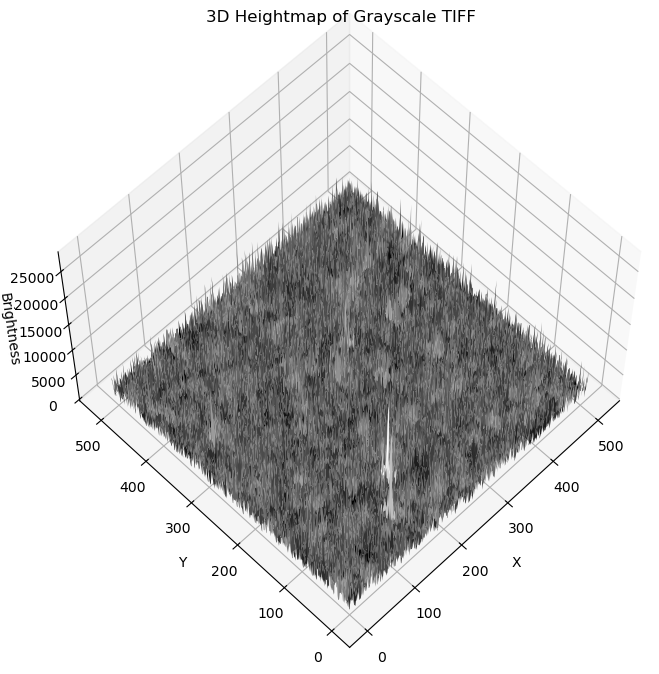

In [5]:
tif_path = os.path.join(output_dir, "simulation_v3.tif")
plot_tif(tif_path, frame=1)

In [6]:
## add functionality to do 3d plot video at some point